In [7]:
import sys
sys.path.append('..')

In [8]:
import pixiedust
from pylab import *

import pandas as pd
from pyquaternion import Quaternion 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from Utilities import *

%matplotlib inline
np.random.seed=1

In [9]:
path1 = '../datasets/10hz.csv'
dataset = pd.read_csv(path1)
length, width = dataset.shape

In [10]:
X, y, _ = getXyAccelerationModel(dataset, limit=length, frequency=10.0, rotate=True)

train = int(0.9 * length)
xTrain, xTest, yTrain, yTest = X[:train], X[train:], y[:train], y[train:] 

## Sanity Check (Acceleration)

In [11]:
limit = 800
integration_error = np.zeros((limit, 6))

Unit test failed! at: 250
[ -2.84281438e-07   1.36097445e-06   1.32294069e-06  -3.10406949e-11
  -2.03060422e-10  -4.61180429e-11]


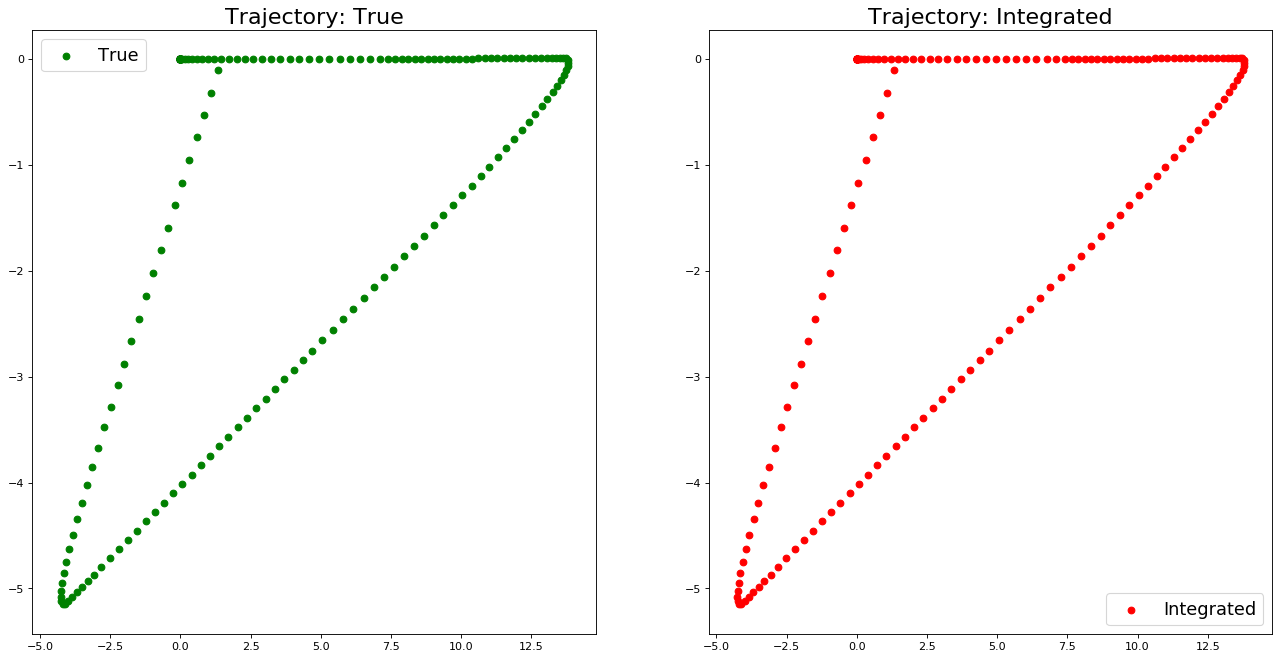

In [18]:
gen2 = integrateTrajectoryAccelerationBody(position=dataset.loc[1, ['x', 'y', 'z']].values,
                                           orientation=dataset.loc[1, ['roll', 'pitch', 'yaw']].values,
                                           linearVelocity=X.loc[0, ['dXB', 'dYB', 'dZB']].values,
                                           angularVelocity=X.loc[0, ['dRoll', 'dPitch', 'dYaw']].values,
                                           
                                           linearAccelerations=y[['d2XB', 'd2YB', 'd2ZB']].values,
                                           angularAccelerations=y[['d2Roll', 'd2Pitch', 'd2Yaw']].values,
                                           frequency=10.0 * np.ones((limit, )))

figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

for i in range(2, limit):
    o, p = next(gen2)
    
    subplot(1, 2, 1)
    legend(['True'], fontsize=16)
    title('Trajectory: True', fontdict={'fontsize':20})
    
    pTrue = dataset.loc[i, ['x', 'y', 'z']]
    oTrue = dataset.loc[i, ['roll', 'pitch', 'yaw']]
    plt.scatter(pTrue[0], pTrue[1], color='green')
    
    subplot(1, 2, 2)
    legend(['Integrated'], fontsize=16)
    title('Trajectory: Integrated', fontdict={'fontsize':20})
    plt.scatter(p[0], p[1], color='red')
    
    integration_error[i - 2] = np.concatenate((p.astype(np.float64) - pTrue.astype(np.float64), 
                                               rad2deg(o.astype(np.float64) - oTrue.astype(np.float64))))
    
    try:
        assert(np.allclose(p.astype(np.float64), pTrue.astype(np.float64)))
        assert(np.allclose(o.astype(np.float64), oTrue.astype(np.float64)))
    except:
        print('Unit test failed! at:', i)
        print(integration_error[i-2])
        break

# Acceleration Prediction Models

### MLP Regressor (one step)

In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

cvModel = MLPRegressor(max_iter=int(10e3), random_state=10)
parameters = {'hidden_layer_sizes':[(80, ), (12, 12)], 'alpha':[1e-6 * np.exp(i) for i in range(11)]}
clf = GridSearchCV(cvModel, parameters, n_jobs=-1).fit(xTrain, yTrain)

mlp_cv = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                      alpha=clf.best_params_['alpha'], 
                      max_iter=int(10e8), 
                      random_state=10).fit(xTrain, yTrain)

In [108]:
yPredicted = pd.DataFrame(mlp_cv.predict(xTest), columns=y.columns)

print('MLP RMSE on test dataset:\n---')

for i in y.columns:
    print(i + '\t', mean_squared_error(yPredicted[i], yTest[i]) ** 0.5)
    
mlp = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                   alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(X, y)

MLP RMSE on test dataset:
---
d2XB	 0.387145666316
d2YB	 0.245177050622
d2ZB	 0.376269090369
d2Roll	 0.193794690703
d2Pitch	 0.354695216806
d2Yaw	 0.319984076801


### Random Forest (one step)

In [62]:
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor(max_depth=25, random_state=10).fit(xTrain, yTrain)

In [63]:
yPredicted2 = pd.DataFrame(randomForest.predict(xTest), columns=y.columns)

print('Random Forest RMSE on test dataset:\n---')

for i in y.columns:
    print(i + '\t', mean_squared_error(yPredicted2[i], yTest[i]) ** 0.5)

Random Forest RMSE on test dataset:
---
d2XB	 0.361503128971
d2YB	 0.253103529983
d2ZB	 0.14004853608
d2Roll	 0.41362972173
d2Pitch	 0.532936514705
d2Yaw	 0.20681833598


In [109]:
def predict(actions, initial, x0, frequency=10, limit=100, model=mlp_cv):
    initialPosition = initial[[0, 1, 2]]
    initialOrientation = initial[[3, 4, 5]]
    
    initialLinearVelocityBody = x0[[0, 1, 2]]
    initialAngularVelocityBody = x0[[3, 4, 5]]
    
    linear_velocities, angular_velocites = np.ones((limit, 3)), np.ones((limit, 3))
    
    for i in range(0, limit):
        if i > 0:
            s0 = np.concatenate((initialLinearVelocityBody, initialAngularVelocityBody, 
                                 initialOrientation[[0, 1]], actions[i]))
        else:
            s0 = x0
            
        s1 = model.predict(s0.reshape(1, -1))[0]
        
        initialOrientation, initialPosition  =\
        next(integrateTrajectoryAccelerationBody(position=initialPosition,
                                                 orientation=initialOrientation,
                                                 
                                                 linearVelocity = s0[[0, 1, 2]],
                                                 angularVelocity = s0[[3, 4, 5]],
                                                 
                                                 linearAccelerations=[s1[[0, 1, 2]]],
                                                 angularAccelerations=[s1[[3, 4, 5]]],
                                        
                                                 frequency=[frequency]))
        
        yield initialPosition, initialOrientation

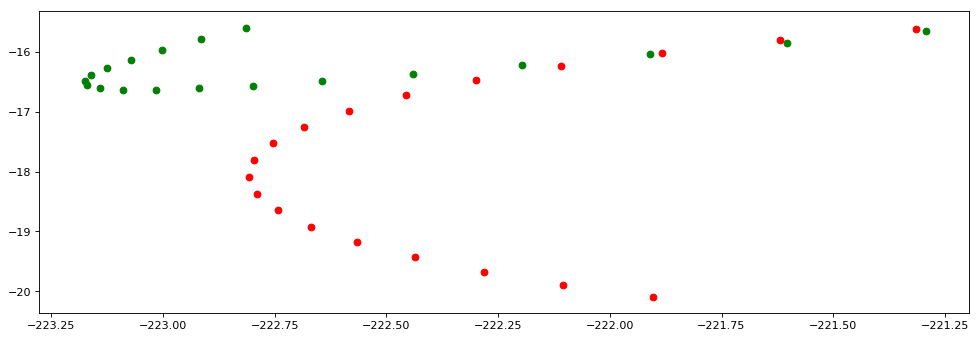

In [133]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

limit = 20
shift = np.random.randint(xTest.shape[0]-limit)
prediction_error = np.zeros((limit, 6))

euler = toEulerianAngle(dataset.loc[train+shift, ['scalar', 'i', 'j', 'k']].values)
gen2 = predict(xTest[['moveForward', 'yawCCW', 'yawCW', 'hover']].values[shift:],
               np.concatenate((dataset.loc[train+shift, ['x', 'y', 'z']].values, euler)), xTest.iloc[shift].values, 10.0)


for i in range(1, limit):
    p, o = next(gen2)

    pTrue = dataset.loc[i+train+shift, ['x', 'y', 'z']]
    oTrue = dataset.loc[i+train+shift, ['roll', 'pitch', 'yaw']]
    plt.scatter(pTrue[0], pTrue[1], color='green')

    plt.scatter(p[0], p[1], color='red')
    
    prediction_error[i-1] = np.concatenate((p-pTrue, np.rad2deg(getAverageAngularVelocity(oTrue, o, 1.0))))

In [111]:
prediction_error_df = pd.DataFrame(prediction_error, columns=['x_error', 'y_error', 'z_error',
                                                              'psi_error', 'theta_error', 'phi_error'])


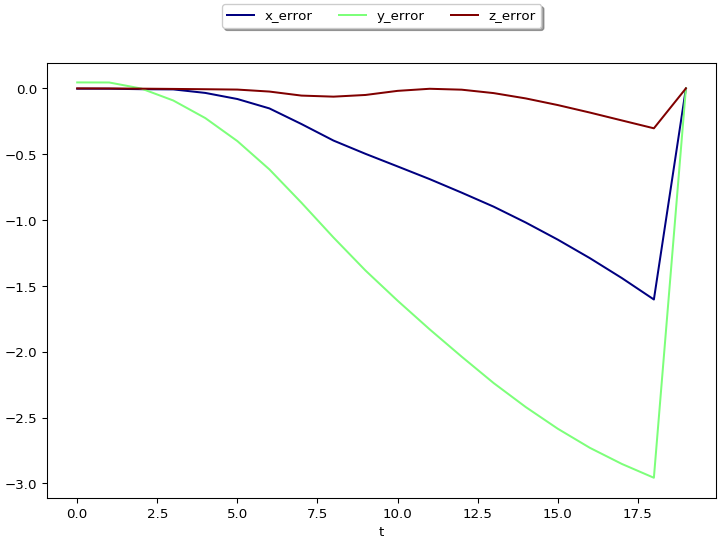

In [52]:
prediction_error_df['t'] = prediction_error_df.index
display(prediction_error_df)


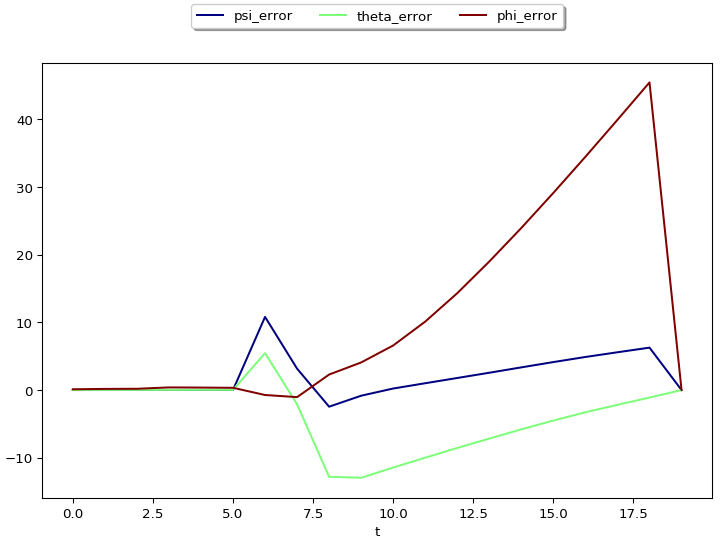

In [53]:
display(prediction_error_df)

In [56]:
joblib.dump(mlp, '../models/mlp.model')

['../models/mlp.model']